In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import torch

from noteify.core.config import SAMPLE_RATE
from noteify.core.datasets import (MaestroDataset, MaestroDatasetProcessed, MusicAugmentor,
                                   MusicSegmentSampler, get_music_dataloader)
from noteify.core.evaluation import get_model_outputs, TranscriptionProcessor
from noteify.core.models import TranscriptionNN
from noteify.core.utils import plot_audio, plot_roll, write_events_to_midi
from noteify.utils import get_rel_pkg_path

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("Warning: Could not find GPU! Using CPU only")

Using the GPU!


In [3]:
data_dir = get_rel_pkg_path("maestro/maestro-v3.0.0")
weights_dir = get_rel_pkg_path("weights/")
session_dir = get_rel_pkg_path("sessions/")

In [4]:
raw_dataset_test = MaestroDataset(data_dir, train=False)

100%|██████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 3126.85it/s]

Loading audio


In [5]:
batch_size = 4

In [6]:
dataset_test = MaestroDatasetProcessed(raw_dataset_test)
sampler_test = MusicSegmentSampler(dataset_test, batch_size)
dataloader_test = get_music_dataloader(dataset_test, sampler_test, num_workers=None, pin_memory=True)

In [10]:
model = TranscriptionNN()
model = model.to(device)
past_train_weights = os.path.abspath(os.path.join(weights_dir, "Experiment 12-08-2020 03-48PM - Copy/Weights Best.pckl"))
model.load_state_dict(torch.load(past_train_weights))

CQT kernels created, time used = 0.0839 seconds


<All keys matched successfully>

C:\Users\Windows\Desktop\Shahir\music-transcription\noteify\core\utils.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Windows\Desktop\Shahir\music-transcription\noteify\core\utils.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


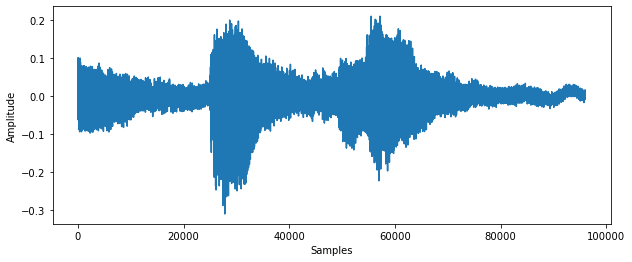

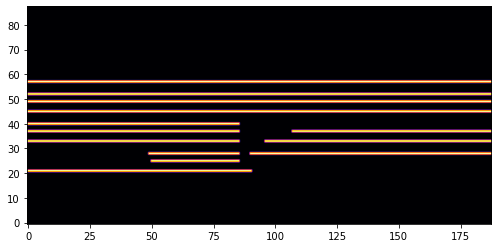

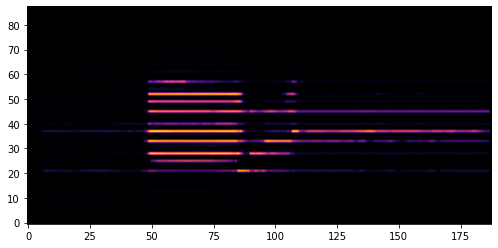

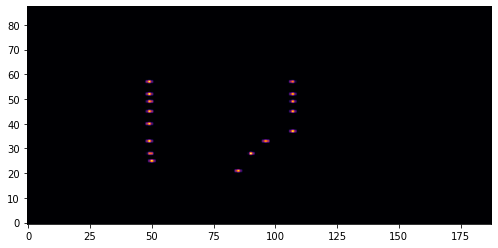

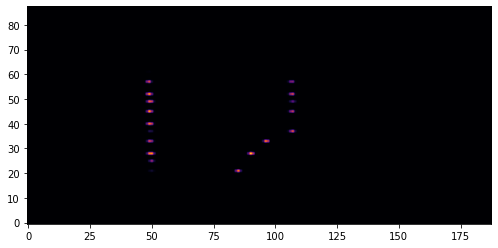

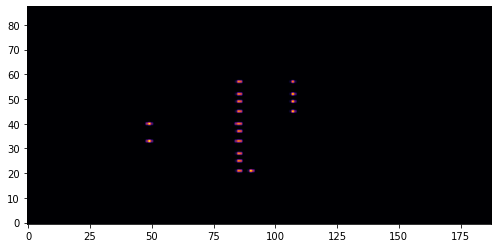

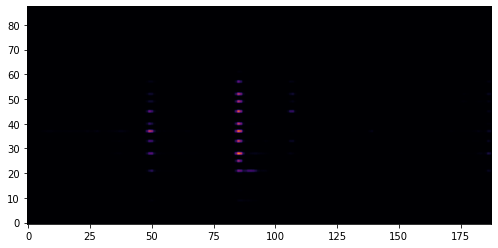

In [11]:
max_iter = 1
sampler_test.generate_segments()
result = get_model_outputs(model, dataloader_test, device, max_iter=max_iter,
                           return_inputs=True, return_targets=True, apply_sigmoid=True)
for n in range(max_iter):
    x = result['inputs'][n].numpy()
    frame_roll = result['targets']['frame_roll'][n].numpy()
    frame_output = result['outputs']['frame_output'][n].numpy()
    reg_onset_roll = result['targets']['reg_onset_roll'][n].numpy()
    reg_onset_output = result['outputs']['reg_onset_output'][n].numpy()
    reg_offset_roll = result['targets']['reg_offset_roll'][n].numpy()
    reg_offset_output = result['outputs']['reg_offset_output'][n].numpy()
    plot_audio(x)
    plot_roll(frame_roll)
    plot_roll(frame_output)
    plot_roll(reg_onset_roll)
    plot_roll(reg_onset_output)
    plot_roll(reg_offset_roll)
    plot_roll(reg_offset_output)

In [12]:
rng = np.random.default_rng()
#rec_id = "750"
rec_id = rng.choice(raw_dataset_test.rec_ids)
x, labels = raw_dataset_test.get_record_data(rec_id)
fnames = raw_dataset_test.get_record_filenames(rec_id)
print("Record ID:", rec_id)
print(fnames)
transcriber = TranscriptionProcessor(model, device, batch_size)
note_events = transcriber.transcribe(x)
shutil.copyfile(fnames[0], "input.wav")
shutil.copyfile(fnames[1], "input.midi")
write_events_to_midi(0, note_events, "output.midi")

  4%|███▍                                                                               | 1/24 [00:00<00:02,  9.95it/s]

Record ID: 1189
('C:\\Users\\Windows\\Desktop\\Shahir\\music-transcription\\maestro\\maestro-v3.0.0\\2008/MIDI-Unprocessed_05_R1_2008_01-04_ORIG_MID--AUDIO_05_R1_2008_wav--4.wav', 'C:\\Users\\Windows\\Desktop\\Shahir\\music-transcription\\maestro\\maestro-v3.0.0\\2008/MIDI-Unprocessed_05_R1_2008_01-04_ORIG_MID--AUDIO_05_R1_2008_wav--4.midi', 'C:\\Users\\Windows\\Desktop\\Shahir\\music-transcription\\maestro\\maestro-v3.0.0\\2008/MIDI-Unprocessed_05_R1_2008_01-04_ORIG_MID--AUDIO_05_R1_2008_wav--4.bin', 'C:\\Users\\Windows\\Desktop\\Shahir\\music-transcription\\maestro\\maestro-v3.0.0\\2008/MIDI-Unprocessed_05_R1_2008_01-04_ORIG_MID--AUDIO_05_R1_2008_wav--4_tree.pckl', 'C:\\Users\\Windows\\Desktop\\Shahir\\music-transcription\\maestro\\maestro-v3.0.0\\2008/MIDI-Unprocessed_05_R1_2008_01-04_ORIG_MID--AUDIO_05_R1_2008_wav--4_events.pckl')


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 10.37it/s]


CQT kernels created, time used = 0.0878 seconds
